# Sigmoid Data Challenge

**Note to Viewer**: This notebook shows my entire workflow for model selection. If you just want to see my final output, scroll down to the bottom to see the final model and result.

In [1]:
import numpy as np
import pandas as pd

In [2]:
from sklearn.model_selection import train_test_split

# Models
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
import xgboost
from sklearn.kernel_ridge import KernelRidge

from sklearn.linear_model import BayesianRidge

from sklearn.linear_model import SGDRegressor

from sklearn.ensemble import AdaBoostRegressor

from sklearn.kernel_approximation import RBFSampler

# Preprocessing
from sklearn.preprocessing import normalize, StandardScaler

# Matplotlib 
import matplotlib.pyplot as plt

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Data Cleaning and Preprocessing

In [5]:
train_df = pd.read_csv('../../Data/Sigmoid/training_data.csv') 

In [6]:
test_df = pd.read_csv('../../Data/Sigmoid/test_data.csv') 

In [7]:
test_df.set_index('url_id', inplace=True)

train_df.set_index('url_id', inplace=True)

A quick look at the data:

In [8]:
train_df.sample(10)

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
url_id,,,,,,,,,,,,,,,,,,,,,
15610,430,8,145,0.696296,1.0,0.817073,4,3,1,0,...,0.50,0.50,-0.140741,-0.166667,-0.100000,0.000000,0.00,0.500000,0.00,2500
18129,375,12,233,0.632287,1.0,0.794118,5,1,1,1,...,0.10,0.25,-0.211111,-0.300000,-0.166667,0.200000,-0.15,0.300000,0.15,790
26680,212,9,1096,0.424440,1.0,0.602465,6,4,3,5,...,0.05,1.00,-0.319477,-1.000000,-0.012500,0.333333,0.25,0.166667,0.25,1800
8499,570,11,509,0.510121,1.0,0.620061,17,9,6,0,...,0.10,1.00,-0.187500,-0.187500,-0.187500,0.000000,0.00,0.500000,0.00,847
31053,142,11,243,0.599174,1.0,0.772059,4,3,1,0,...,0.10,0.50,-0.150000,-0.200000,-0.100000,0.000000,0.00,0.500000,0.00,3000
31733,132,10,152,0.556291,1.0,0.572816,8,2,5,0,...,0.10,0.60,-0.397222,-0.666667,-0.125000,0.900000,0.60,0.400000,0.60,1300
21588,305,12,980,0.478353,1.0,0.670819,23,1,1,0,...,0.05,1.00,-0.308796,-1.000000,-0.100000,0.000000,0.00,0.500000,0.00,2100
34283,91,10,1059,0.462500,1.0,0.638199,1,1,11,1,...,0.05,0.80,-0.253472,-0.600000,-0.100000,0.000000,0.00,0.500000,0.00,2200
22030,296,13,849,0.492857,1.0,0.718686,5,1,2,1,...,0.05,0.60,-0.295288,-1.000000,-0.125000,0.000000,0.00,0.500000,0.00,779


In [9]:
train_df.shape[0]

28786

Feature Names

In [10]:
train_df.columns.tolist()

[' timedelta',
 ' n_tokens_title',
 ' n_tokens_content',
 ' n_unique_tokens',
 ' n_non_stop_words',
 ' n_non_stop_unique_tokens',
 ' num_hrefs',
 ' num_self_hrefs',
 ' num_imgs',
 ' num_videos',
 ' average_token_length',
 ' num_keywords',
 ' data_channel_is_lifestyle',
 ' data_channel_is_entertainment',
 ' data_channel_is_bus',
 ' data_channel_is_socmed',
 ' data_channel_is_tech',
 ' data_channel_is_world',
 ' kw_min_min',
 ' kw_max_min',
 ' kw_avg_min',
 ' kw_min_max',
 ' kw_max_max',
 ' kw_avg_max',
 ' kw_min_avg',
 ' kw_max_avg',
 ' kw_avg_avg',
 ' self_reference_min_shares',
 ' self_reference_max_shares',
 ' self_reference_avg_sharess',
 ' weekday_is_monday',
 ' weekday_is_tuesday',
 ' weekday_is_wednesday',
 ' weekday_is_thursday',
 ' weekday_is_friday',
 ' weekday_is_saturday',
 ' weekday_is_sunday',
 ' is_weekend',
 ' LDA_00',
 ' LDA_01',
 ' LDA_02',
 ' LDA_03',
 ' LDA_04',
 ' global_subjectivity',
 ' global_sentiment_polarity',
 ' global_rate_positive_words',
 ' global_rate_neg

Separate X and Y

In [11]:
x = train_df.drop(labels=[' shares'], axis=1)

y = train_df[' shares']

In [54]:
non_binary_features = x.columns[x.max()!=1]

There are 36 continuous features:

In [55]:
non_binary_features

Index([' timedelta', ' n_tokens_title', ' n_tokens_content',
       ' n_unique_tokens', ' n_non_stop_words', ' n_non_stop_unique_tokens',
       ' num_hrefs', ' num_self_hrefs', ' num_imgs', ' num_videos',
       ' average_token_length', ' num_keywords', ' kw_min_min', ' kw_max_min',
       ' kw_avg_min', ' kw_min_max', ' kw_max_max', ' kw_avg_max',
       ' kw_min_avg', ' kw_max_avg', ' kw_avg_avg',
       ' self_reference_min_shares', ' self_reference_max_shares',
       ' self_reference_avg_sharess', ' LDA_00', ' LDA_01', ' LDA_02',
       ' LDA_03', ' LDA_04', ' global_sentiment_polarity',
       ' global_rate_positive_words', ' global_rate_negative_words',
       ' avg_negative_polarity', ' min_negative_polarity',
       ' max_negative_polarity', ' abs_title_subjectivity'],
      dtype='object')

In [116]:
x[non_binary_features].describe()

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,LDA_02,LDA_03,LDA_04,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,avg_negative_polarity,min_negative_polarity,max_negative_polarity,abs_title_subjectivity
count,28786.000000,28786.000000,28786.000000,28786.000000,28786.000000,28786.000000,28786.000000,28786.000000,28786.000000,28786.000000,...,28786.000000,28786.000000,28786.000000,28786.000000,28786.000000,28786.000000,28786.000000,28786.000000,28786.000000,28786.000000
mean,353.520635,10.403460,546.455082,0.555111,1.006600,0.695780,10.873063,3.301674,4.548496,1.259432,...,0.216478,0.223049,0.234595,0.118936,0.039636,0.016630,-0.260026,-0.522700,-0.107939,0.341162
std,214.420324,2.121334,470.409467,4.130828,6.138155,3.830214,11.155409,3.868232,8.342588,4.183587,...,0.282305,0.294676,0.289643,0.096983,0.017406,0.010841,0.127850,0.290469,0.095253,0.189085
min,8.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-0.393750,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,163.000000,9.000000,245.000000,0.470735,1.000000,0.625926,4.000000,1.000000,1.000000,0.000000,...,0.028571,0.028571,0.028574,0.057387,0.028398,0.009640,-0.329167,-0.700000,-0.125000,0.166667
50%,337.000000,10.000000,410.000000,0.539302,1.000000,0.691043,8.000000,3.000000,1.000000,0.000000,...,0.040004,0.040001,0.040762,0.119223,0.039047,0.015385,-0.253756,-0.500000,-0.100000,0.500000
75%,542.000000,12.000000,716.000000,0.608527,1.000000,0.755155,14.000000,4.000000,4.000000,1.000000,...,0.335049,0.371804,0.400693,0.177389,0.050251,0.021747,-0.187500,-0.300000,-0.050000,0.500000
max,731.000000,23.000000,8474.000000,701.000000,1042.000000,650.000000,162.000000,74.000000,128.000000,75.000000,...,0.919999,0.925542,0.927191,0.655000,0.155488,0.184932,0.000000,0.000000,0.000000,0.500000


In [118]:
describe_continuous = x[non_binary_features].describe()

In [120]:
describe_continuous.transpose()

,count,mean,std,min,25%,50%,75%,max
timedelta,28786.0,353.520635,214.420324,8.00000,163.000000,337.000000,542.000000,731.000000
n_tokens_title,28786.0,10.403460,2.121334,2.00000,9.000000,10.000000,12.000000,23.000000
n_tokens_content,28786.0,546.455082,470.409467,0.00000,245.000000,410.000000,716.000000,8474.000000
n_unique_tokens,28786.0,0.555111,4.130828,0.00000,0.470735,0.539302,0.608527,701.000000
n_non_stop_words,28786.0,1.006600,6.138155,0.00000,1.000000,1.000000,1.000000,1042.000000
n_non_stop_unique_tokens,28786.0,0.695780,3.830214,0.00000,0.625926,0.691043,0.755155,650.000000
num_hrefs,28786.0,10.873063,11.155409,0.00000,4.000000,8.000000,14.000000,162.000000
num_self_hrefs,28786.0,3.301674,3.868232,0.00000,1.000000,3.000000,4.000000,74.000000
num_imgs,28786.0,4.548496,8.342588,0.00000,1.000000,1.000000,4.000000,128.000000
num_videos,28786.0,1.259432,4.183587,0.00000,0.000000,0.000000,1.000000,75.000000


In [121]:
describe_continuous.transpose().to_csv('desc_cont.csv')

and the rest are binary

In [84]:
x_norm = x.copy()

In [77]:
x.shape

(28786, 59)

In [99]:
y.max()

843300

In [101]:
y.min()

1

In [102]:
y.mean()

3428.6585492947961

In [103]:
y.std()

12693.940388418016

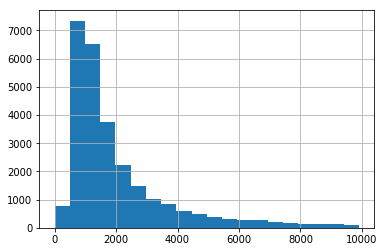

In [109]:
plt.hist(y[y<10000], bins=20)
plt.grid()

In [107]:
y.describe()

count     28786.000000
mean       3428.658549
std       12693.940388
min           1.000000
25%         940.250000
50%        1400.000000
75%        2800.000000
max      843300.000000
Name:  shares, dtype: float64

In [123]:
sum(y>10000)

1579

In [91]:
x_norm[non_binary_features] = normalize(x_norm[non_binary_features], axis=0)

Split into Training and Validation Data

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [92]:
x_norm_train, x_norm_test, y_train, y_test = train_test_split(x_norm, y, test_size=0.33, random_state=42)

Define the MAPE metric

In [13]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

and the Leaderboard scoring metric

In [14]:
def leaderboard_score(y_true, y_pred):
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return (1-(mape/100))*100

# Model Evaluation

## Lasso Regression

In [14]:
lr = Lasso(alpha=1, max_iter=10000)

lr.fit(x_train, y_train)

y_pred_lr = lr.predict(x_test)

leaderboard_score(y_test, y_pred_lr)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


-72.686562617323773

With normalized Data:

In [93]:
lr = Lasso(alpha=1, max_iter=10000)

lr.fit(x_norm_train, y_train)

y_pred_lr = lr.predict(x_norm_test)

leaderboard_score(y_test, y_pred_lr)

-88.233430254897854

### Feature Importance

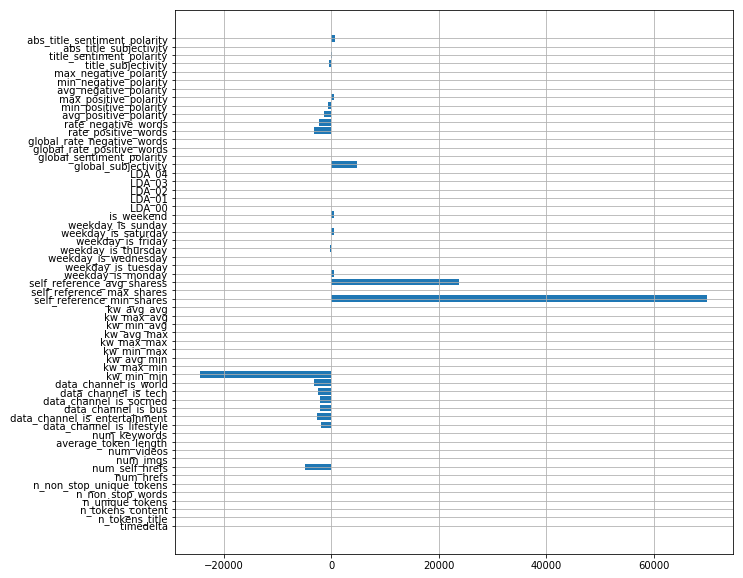

In [115]:
fig = plt.figure(figsize=(10,10))
plt.barh(range(len(lr.coef_)), lr.coef_, tick_label=x.columns)
plt.grid()

## XGBoost

In [15]:
xr = xgboost.XGBRegressor(n_estimators=200, learning_rate=0.01, max_depth=8, subsample=0.5, reg_alpha=0, reg_lambda=1)

xr.fit(x_train, y_train)

y_pred_xr = xr.predict(x_test)

leaderboard_score(y_test, y_pred_xr)

-43.842916826787224

With normalized data

In [88]:
xr = xgboost.XGBRegressor(n_estimators=200, learning_rate=0.01, max_depth=8, subsample=0.5, reg_alpha=0, reg_lambda=1)

xr.fit(x_norm_train, y_train)

y_pred_xr = xr.predict(x_norm_test)

leaderboard_score(y_test, y_pred_xr)

-42.872365862670314

Best XGB Regressor: -43.84

In [99]:
xr

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.01, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=200, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.5)

### Feature Importance

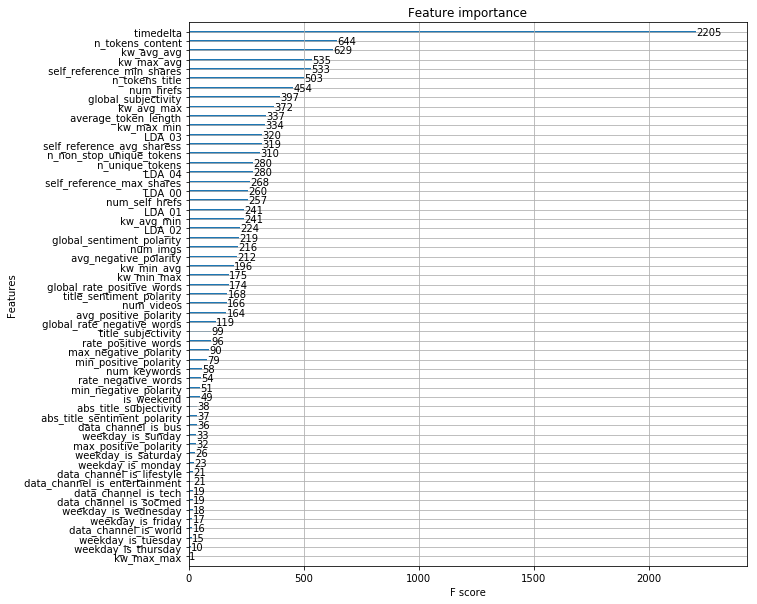

In [179]:
fig, ax = plt.subplots(figsize=(10, 10))
xgboost.plot_importance(xr, ax=ax)

In [137]:
y_pred_xr.std()

3649.937

In [81]:
def train_test_xgbr(x_train, y_train, x_test, y_test, n_estimators=200, learning_rate=0.01, max_depth=6):
    xr = xgboost.XGBRegressor(n_estimators=n_estimators, learning_rate=0.01, max_depth=6)
    xr.fit(x_train, y_train)
    y_pred_xr = xr.predict(x_test)
    return leaderboard_score(y_test, y_pred_xr)

## SVM

In [18]:
svr = SVR(C=100, epsilon=0.05)

svr.fit(x_train, y_train)

y_pred_svr = svr.predict(x_test)

leaderboard_score(y_test, y_pred_svr)

31.162494374916307

Best SVM Regressor: 31.16

With normalized data:

In [94]:
svr = SVR(C=100, epsilon=0.05)

svr.fit(x_norm_train, y_train)

y_pred_svr = svr.predict(x_norm_test)

leaderboard_score(y_test, y_pred_svr)

33.854500389750378

In [162]:
svr

SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.05, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [163]:
y_pred_svr.std()

0.93170901670463047

## Random Forest 

In [170]:
rfr = RandomForestRegressor(n_estimators=100, criterion='mae', n_jobs=-1)

rfr.fit(x_train, y_train)

y_pred_rfr = rfr.predict(x_test)

leaderboard_score(y_test, y_pred_rfr)

-124.94114388160247

In [168]:
rfr

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

## K Nearest Neighbor

In [210]:
knnr = KNeighborsRegressor(n_neighbors=25, n_jobs=-1, weights='distance', p=1, leaf_size=20)

knnr.fit(x_train, y_train)

y_pred_knnr = knnr.predict(x_test)

leaderboard_score(y_test, y_pred_knnr)

-52.996335101665657

Best KNN Regressor: -52.99

In [207]:
knnr

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=25, p=1,
          weights='distance')

## Kernel ridge regression.

In [17]:
krr = KernelRidge(alpha=0.1, kernel='rbf')

krr.fit(x_train, y_train)

y_pred_krr = krr.predict(x_test)

leaderboard_score(y_test, y_pred_krr)

0.01997611724882109

Best Kernel Ridge Regressor: 0.019

In [18]:
y_pred_krr.std()

7.9096085605981905

In [97]:
krr = KernelRidge(alpha=0.1, kernel='rbf')

krr.fit(x_norm_train, y_train)

y_pred_krr = krr.predict(x_test)

leaderboard_score(y_test, y_pred_krr)

0.0

In [17]:
krr

KernelRidge(alpha=0.1, coef0=1, degree=3, gamma=None, kernel='rbf',
      kernel_params=None)

## Bayesian Ridge Regression

In [39]:
brr = BayesianRidge(n_iter=500, compute_score=True, fit_intercept=True, lambda_1=0.001, lambda_2=0.001)
brr.fit(x_train, y_train)

y_pred_brr = brr.predict(x_test)

leaderboard_score(y_test, y_pred_brr)

-77.328294818452918

Best Bayesian Ridge Regressor: -77.32

In [40]:
y_pred_brr.std()

2261.6059384263367

In [41]:
brr

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=True, copy_X=True,
       fit_intercept=True, lambda_1=0.001, lambda_2=0.001, n_iter=500,
       normalize=False, tol=0.001, verbose=False)

## Stochastic Gradient Descent

In [32]:
sgdr = SGDRegressor(max_iter=1000, tol=0.1)
sgdr.fit(x_train, y_train)

y_pred_sgdr = sgdr.predict(x_test)

leaderboard_score(y_test, y_pred_sgdr)

-1.8724508072426123e+19

With Normalized data:

In [89]:
sgdr = SGDRegressor(max_iter=1000, tol=0.1)
sgdr.fit(x_norm_train, y_train)

y_pred_sgdr = sgdr.predict(x_norm_test)

leaderboard_score(y_test, y_pred_sgdr)

-91.398607382226899

### SGD + RBF Sampler

In [41]:
rbf_feature = RBFSampler(gamma=1)
sgdr = SGDRegressor(max_iter=1000, tol=0.1)
sgdr.fit(rbf_feature.fit_transform(x_train), y_train)

y_pred_sgdr = sgdr.predict(rbf_feature.transform(x_test))

leaderboard_score(y_test, y_pred_sgdr)

-86.880604356552809

with normalized data:

In [95]:
rbf_feature = RBFSampler(gamma=1)
sgdr = SGDRegressor(max_iter=1000, tol=0.1)
sgdr.fit(rbf_feature.fit_transform(x_norm_train), y_train)

y_pred_sgdr = sgdr.predict(rbf_feature.transform(x_norm_test))

leaderboard_score(y_test, y_pred_sgdr)

-89.154581756455713

Best SGD Regressor: -86.88

In [42]:
y_pred_sgdr.std()

561.67760102905629

In [43]:
sgdr

SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', max_iter=1000, n_iter=None, penalty='l2',
       power_t=0.25, random_state=None, shuffle=True, tol=0.1, verbose=0,
       warm_start=False)

## Adaboost with SGD

In [27]:
adasgd = AdaBoostRegressor(base_estimator=SGDRegressor(max_iter=1000), n_estimators=100, learning_rate=0.1)
adasgd.fit(x_train, y_train)

y_pred_adasgd = adasgd.predict(x_test)

leaderboard_score(y_test, y_pred_adasgd)

-1.9815663836043556e+18

Best Regressor: 30.019

With Normalized data:

In [96]:
adasgd = AdaBoostRegressor(base_estimator=SGDRegressor(max_iter=1000), n_estimators=100, learning_rate=0.1)
adasgd.fit(x_norm_train, y_train)

y_pred_adasgd = adasgd.predict(x_norm_test)

leaderboard_score(y_test, y_pred_adasgd)

-2873.2610938329208

In [28]:
y_pred_adasgd.std()

1.1157966020808546e+19

In [26]:
adasgd

AdaBoostRegressor(base_estimator=SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.05, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
         learning_rate=0.1, loss='linear', n_estimators=10,
         random_state=None)

## Adaboost with SVM

In [24]:
adasvr = AdaBoostRegressor(base_estimator= SVR(C=100, epsilon=0.05), n_estimators=10, learning_rate=0.1)
adasvr.fit(x_train, y_train)

y_pred_adasvr = adasvr.predict(x_test)

leaderboard_score(y_test, y_pred_adasvr)

30.019282218125554

Best Regressor: 30.019

In [25]:
y_pred_adasvr.std()

0.63087321136755414

In [26]:
adasvr

AdaBoostRegressor(base_estimator=SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.05, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
         learning_rate=0.1, loss='linear', n_estimators=10,
         random_state=None)

## Ensembling

### Kernel Ridge Regression and SVM

In [31]:
leaderboard_score(y_test, (y_pred_krr+y_pred_svr)/2)

42.718521149260233

In [98]:
leaderboard_score(y_test, (y_pred_krr+y_pred_svr)/2)

42.425419873867199

# Submission

##  Attempt 1:  XGBoost

In [110]:
xr = xgboost.XGBRegressor(n_estimators=200, learning_rate=0.01, max_depth=8, subsample=0.5, reg_alpha=0, reg_lambda=1)
xr.fit(x, y)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.01, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=None, n_estimators=200, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.5)

In [111]:
y_sub = xr.predict(test_df)

In [112]:
y_sub

array([ 1598.69372559,  1691.77563477,  2301.03686523, ...,  4845.50390625,
        3221.55883789,  2260.63842773], dtype=float32)

In [119]:
sub_df = pd.DataFrame({'url_id': test_df.index.tolist(),'shares': y_sub})
# Shuffle the columns to the correct positions
sub_df = sub_df[['url_id', 'shares']]
# Save to CSV
sub_df.to_csv('submission1.csv', index=False)

**Actual Leaderboard Score:** -40.7677 

**Actual MAPE:** 140.767

##  Attempt 2:  SVM

In [ ]:
svr = SVR(C=100, epsilon=0.05)
svr.fit(x, y)

SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.05, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [161]:
y_sub = svr.predict(test_df)

In [158]:
sub_df = pd.DataFrame({'url_id': test_df.index.tolist(),'shares': y_sub})
# Shuffle the columns to the correct positions
sub_df = sub_df[['url_id', 'shares']]
# Save to CSV
sub_df.to_csv('submission2.csv', index=False)

**Actual Leaderboard Score**: 33.8468

**Actual MAPE**: 66.15

##  Attempt 3:  SVM + KRR

**This is the final version that was submited**

In [68]:
svr = SVR(C=100, epsilon=0.05)
svr.fit(x, y)

SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.05, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [69]:
krr = KernelRidge(alpha=0.1, kernel='rbf')
krr.fit(x, y)

KernelRidge(alpha=0.1, coef0=1, degree=3, gamma=None, kernel='rbf',
      kernel_params=None)

In [70]:
y_ens_krrr = krr.predict(test_df)
y_ens_svr = svr.predict(test_df)

In [71]:
y_ens1 = (y_ens_xr+y_ens_svr)/2

In [22]:
sub_df = pd.DataFrame({'url_id': test_df.index.tolist(),'shares': y_ens1})
# Shuffle the columns to the correct positions
sub_df = sub_df[['url_id', 'shares']]
# Save to CSV
sub_df.to_csv('submission3.csv', index=False)